In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This is required in order to load the development and test images into Google Colab
!unzip "/content/drive/MyDrive/ENEL-Group/Final Project/Project Files/Train.zip" -d "/content"
!unzip "/content/drive/MyDrive/ENEL-Group/Final Project/Project Files/TrainEnhanced.zip" -d "/content"
!unzip "/content/drive/MyDrive/ENEL-Group/Final Project/Project Files/Test.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Test/09644.png  
  inflating: /content/__MACOSX/Test/._09644.png  
  inflating: /content/Test/01218.png  
  inflating: /content/__MACOSX/Test/._01218.png  
  inflating: /content/Test/00106.png  
  inflating: /content/__MACOSX/Test/._00106.png  
  inflating: /content/Test/07669.png  
  inflating: /content/__MACOSX/Test/._07669.png  
  inflating: /content/Test/10315.png  
  inflating: /content/__MACOSX/Test/._10315.png  
  inflating: /content/Test/04360.png  
  inflating: /content/__MACOSX/Test/._04360.png  
  inflating: /content/Test/02711.png  
  inflating: /content/__MACOSX/Test/._02711.png  
  inflating: /content/Test/12502.png  
  inflating: /content/__MACOSX/Test/._12502.png  
  inflating: /content/Test/05095.png  
  inflating: /content/__MACOSX/Test/._05095.png  
  inflating: /content/Test/02922.png  
  inflating: /content/__MACOSX/Test/._02922.png  
  inflating: /content/Test/09877.png  
  inflating: /conten

# ENEL 645 Project - Traffic Sign Recognition Image Classification

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage import transform
from skimage import exposure
from skimage import io
from PIL import Image, ImageEnhance

import os

np.random.seed(42)

The GTSRB dataset consists of images belonging to 43 different classes. The class mapping to their corresponding integer value is performed below.

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# setting the number of classes
num_classes = len(classes)

## 1. Loading GTSRB dataset into notebook

### Function definitions for loading development and test datasets into notebook

In [5]:
img_height = 32
img_width = 32

In [6]:
# function to load the GTSRB development dataset
def load_development_dataset(train_directory_name='Train'):
  X_dev = []
  Y_dev = []

  cur_path = '/content/' + train_directory_name
#   cur_path = './content/' + train_directory_name # Uncomment for local path


  # loop through each class integer values
  for i in range(num_classes):
    # retrieves the path for photos belonging to the same class
    class_path = os.path.join(cur_path, str(i))
    image_name_list = os.listdir(class_path)


    # iterates through each image file names
    for image_name in image_name_list:

      try:
        # create image path
        image_path = class_path + '/' + image_name

        # open and resize the image to 32x32 pixels
        image = Image.open(image_path)
        image = image.resize((img_height,img_width))

        # convert image into a numpy array
        image = np.array(image)

        # store image as numpy array into data list with the respective label class
        X_dev.append(image)
        Y_dev.append(i)
        print('Finished loading:', image_path)

      except Exception as e:
        print('Error loading train image')
        print(e)
    
  # convert development dataset into numpy array
  X_dev = np.array(X_dev)
  Y_dev = np.array(Y_dev)

  return X_dev, Y_dev

In [7]:
# function to load the GTSRB test dataset
def load_test_dataset(filepath='/content/drive/MyDrive/ENEL-Group/Final Project/Project Files/Test.csv', enhance_contrast=False):
# def load_test_dataset(filepath='./content/Test.csv', enhance_contrast=False): # Uncomment if running locally
  test_df = pd.read_csv(filepath)
  test_paths = test_df['Path']

  X_test = []
  Y_test = np.array(test_df['ClassId'])

  cur_path = "/content/"
#   cur_path = "./content/" # Uncomment if running locally


  for path in test_paths:
    try:
      # Create and store image path
      image_path = cur_path + path

      # Open and resize image using PIL library
      image = Image.open(image_path)
      image = image.resize((img_height,img_width))
      
      # Convert image to a numpy array
      image = np.array(image)

      if enhance_contrast:
          # Apply contrast enhancement
          image = exposure.equalize_adapthist(image, clip_limit=0.1)
          # Store image as numpy array into data list with the respective label class
          X_test.append( (image * 255).astype(np.uint8) )
      else:
          X_test.append(image)
   
      print('Finished loading:', image_path)

    except:
      print("Error")

  # Convert X_test to a numpy array
  X_test = np.array(X_test)
  
  return X_test, Y_test

In [8]:
X_dev_ori, Y_dev_ori = load_development_dataset() # load original train images
X_dev, Y_dev = load_development_dataset('TrainEnhanced') # load enhanced train images
X_test_ori, Y_test_ori = load_test_dataset() # load test images with no enhancements
X_test, Y_test = load_test_dataset(enhance_contrast=True) # load test images with enhancements

Streaming output truncated to the last 5000 lines.
Finished loading: /content/Test/07630.png
Finished loading: /content/Test/07631.png
Finished loading: /content/Test/07632.png
Finished loading: /content/Test/07633.png
Finished loading: /content/Test/07634.png
Finished loading: /content/Test/07635.png
Finished loading: /content/Test/07636.png
Finished loading: /content/Test/07637.png
Finished loading: /content/Test/07638.png
Finished loading: /content/Test/07639.png
Finished loading: /content/Test/07640.png
Finished loading: /content/Test/07641.png
Finished loading: /content/Test/07642.png
Finished loading: /content/Test/07643.png
Finished loading: /content/Test/07644.png
Finished loading: /content/Test/07645.png
Finished loading: /content/Test/07646.png
Finished loading: /content/Test/07647.png
Finished loading: /content/Test/07648.png
Finished loading: /content/Test/07649.png
Finished loading: /content/Test/07650.png
Finished loading: /content/Test/07651.png
Finished loading: /conten

In [9]:
print('Development Dataset Original:')
print('Dev Samples:', X_dev_ori.shape)
print('Dev Labels:', Y_dev_ori.shape)
print()
print('Development Dataset Enhanced:')
print('Dev Samples:', X_dev.shape)
print('Dev Labels:', Y_dev.shape)
print()
print('Test Dataset Original:')
print('Test Samples:', X_test_ori.shape)
print('Test Labels:', Y_test_ori.shape)
print()
print('Test Dataset Enhanced:')
print('Test Samples:', X_test.shape)
print('Test Labels:', Y_test.shape)

Development Dataset Original:
Dev Samples: (39209, 32, 32, 3)
Dev Labels: (39209,)

Development Dataset Enhanced:
Dev Samples: (39209, 32, 32, 3)
Dev Labels: (39209,)

Test Dataset Original:
Test Samples: (12630, 32, 32, 3)
Test Labels: (12630,)

Test Dataset Enhanced:
Test Samples: (12630, 32, 32, 3)
Test Labels: (12630,)


After loading the GTSRB development and test datasets into the notebook we analyzed the number of sample in each grouping.

There are 39209 samples in the development dataset and 12630 samples in the test dataset. Each of the samples have been resized to the dimensions of 32x32 while still keeping the RGB color information resulting in 3 channels.

## 2. Exploring the GTSRB datasets

Here is a distribution of the development dataset displaying the number of samples in each class.

In [10]:
# get the number of samples in each class
unique, counts = np.unique(Y_dev_ori, return_counts=True)
label_names = []

# get a list of the label names corresponding with the integer value
for i in range(num_classes):
  label_names.append(classes[i])

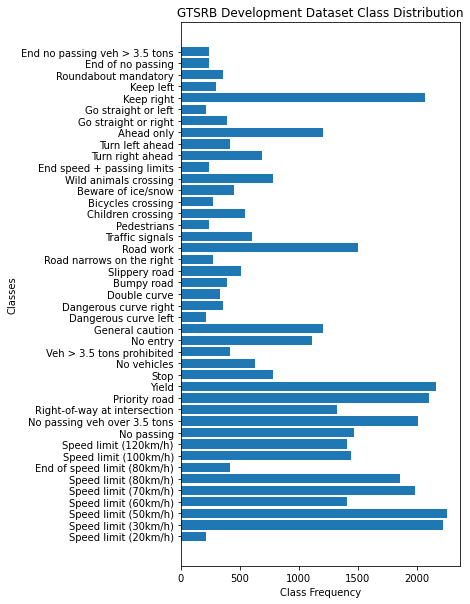

In [11]:
# Plotting the number of images in each class
plt.figure(figsize=(5,10))  
plt.barh(label_names, counts)
plt.xlabel('Class Frequency')
plt.ylabel('Classes')
plt.title('GTSRB Development Dataset Class Distribution')
plt.show()

From the distribution of the development dataset, we determined that there is a class imbalance between the number of samples for each class. Because of this imbalance we will have to apply stratification in order to keep the frequencies the same when splitting the development dataset into training and validation sets.

Comparing the original images with the enhanced images on development set


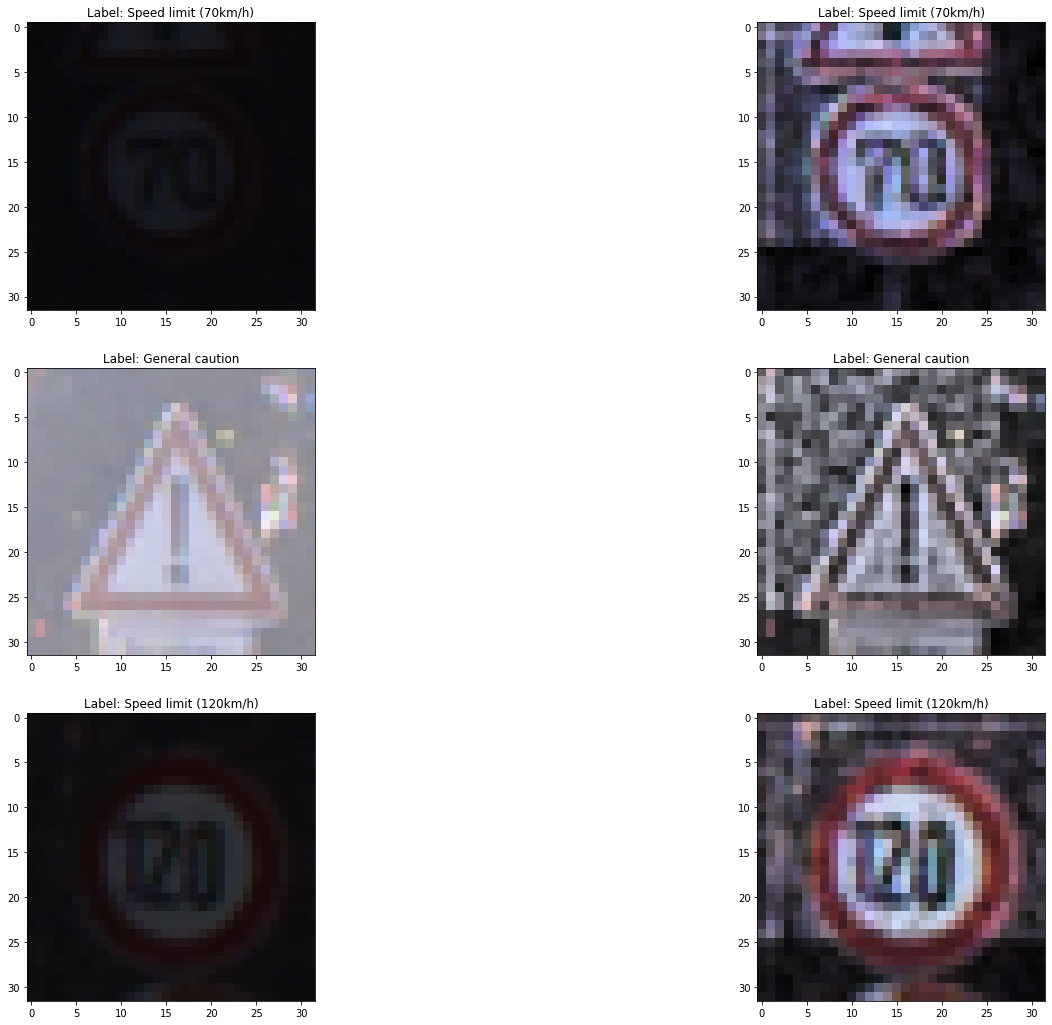

In [12]:
# showing contrast enhancement on three samples
sample_indexes = [7779, 25656, 12528]
plt.figure(figsize = (24,18))

for (ii, jj) in enumerate(sample_indexes):
  plt.subplot(3,2,(ii)*2+1)
  plt.imshow(X_dev_ori[jj])
  plt.title("Label: %s" %classes[Y_dev_ori[jj]])
  plt.subplot(3,2,(ii)*2+2)
  plt.imshow(X_dev[jj])
  plt.title("Label: %s" %classes[Y_dev[jj]])
plt.show()

Comparing the original images with the enhanced images on test set

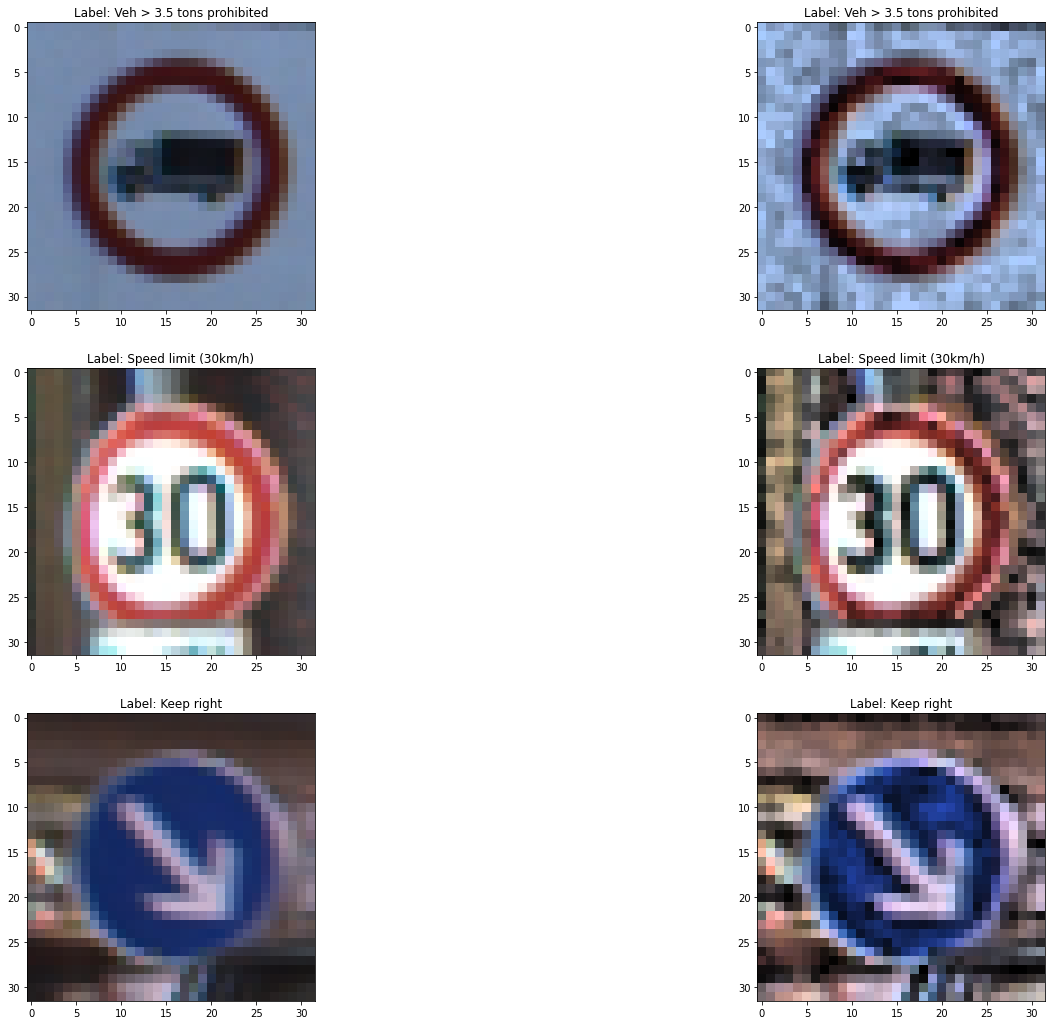

In [13]:
# showing contrast enhancement on three samples
sample_indexes = [0, 1, 2]
plt.figure(figsize = (24,18))

for (ii, jj) in enumerate(sample_indexes):
  plt.subplot(3,2,(ii)*2+1)
  plt.imshow(X_test_ori[jj])
  plt.title("Label: %s" %classes[Y_test_ori[jj]])
  plt.subplot(3,2,(ii)*2+2)
  plt.imshow(X_test[jj])
  plt.title("Label: %s" %classes[Y_test[jj]])
plt.show()

Display random image samples from development set.

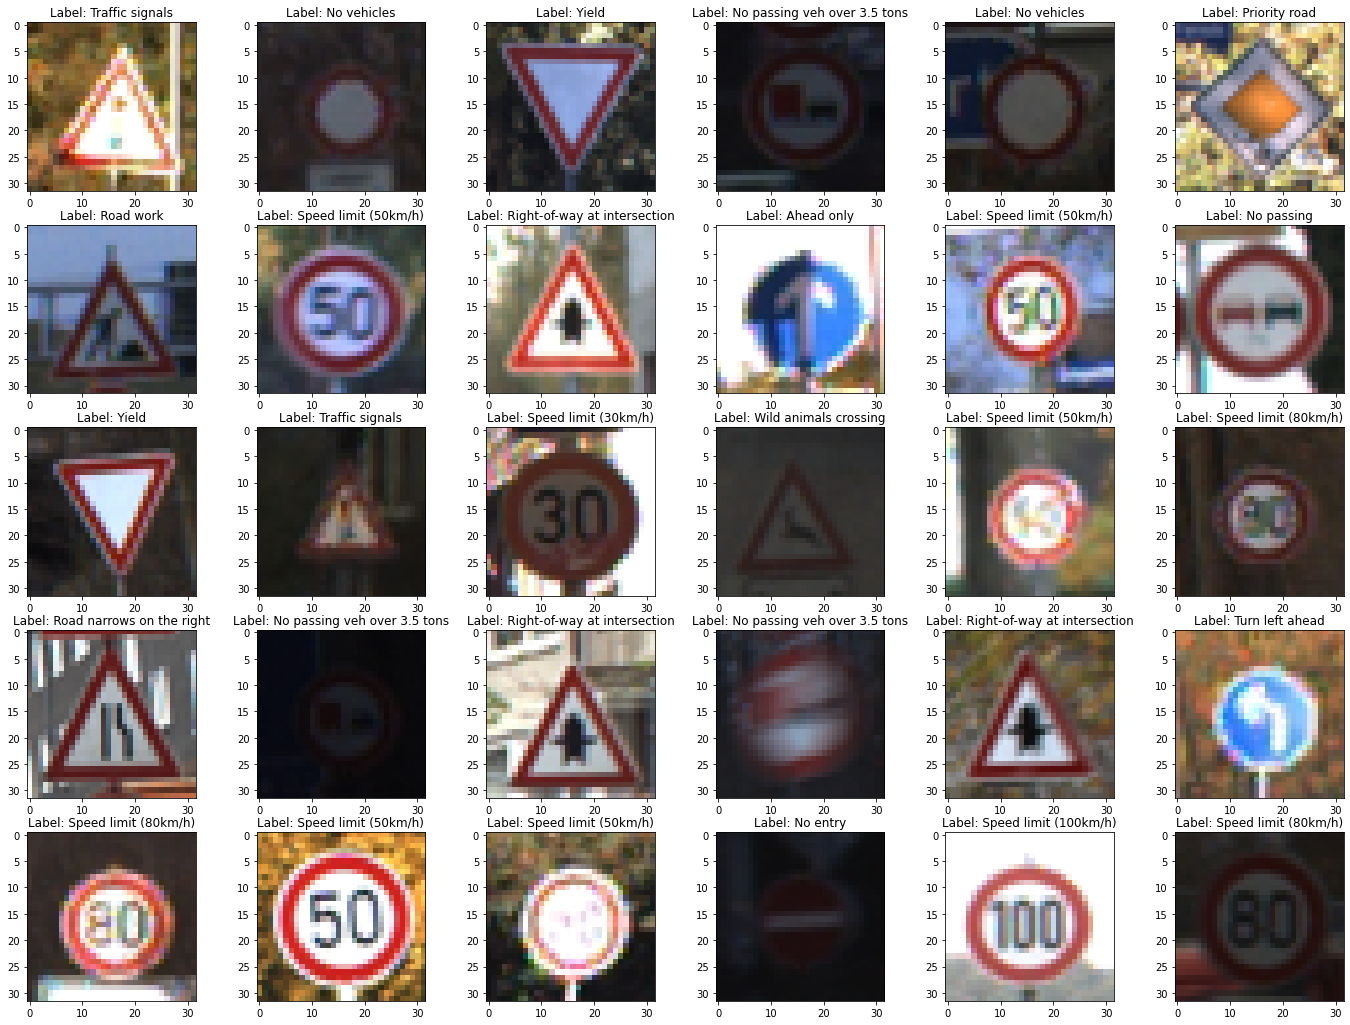

In [14]:
# display 30 random samples from the development dataset
sample_indexes = np.random.choice(np.arange(X_dev_ori.shape[0], dtype = int), size = 30, replace = False)
plt.figure(figsize = (24,18))

for (ii, jj) in enumerate(sample_indexes):
  plt.subplot(5,6,ii+1)
  plt.imshow(X_dev_ori[jj])
  plt.title("Label: %s" % classes[Y_dev_ori[jj]])
plt.show()

## 3. Split data into train and validation sets


After analyzing the dataset that we are working with, the next step is to split the development dataset into training and validation sets. Here we are using the sklearn train_test_split function to split our development set into 75% training and 25% validation. Furthermore, we have enabled shuffling to randomize the sample prior to splitting and applying stratification to keep the frequency distribution the same between the two sets.

In [15]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.25, random_state=42, shuffle=True, stratify=Y_dev)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev_ori, Y_dev_ori, test_size=0.25, random_state=42, shuffle=True, stratify=Y_dev_ori)

print('Training samples:', X_train.shape)
print('Training labels:', Y_train.shape)
print('Validation samples:', X_val.shape)
print('Validation labels:', Y_val.shape)

Training samples: (29406, 32, 32, 3)
Training labels: (29406,)
Validation samples: (9803, 32, 32, 3)
Validation labels: (9803,)


## 4. One Hot Encode Labels

Once the dataset has been split into training, validation, and test sets, the step is to one hot encode the labels. Since the labels in this image classification problem are not ordinal, we must transform the categorical representation of the label into a numerical value that the machine learning algorithm can understand.

In [16]:
# One hot encode the training, validation, and test set labels
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test_ori)

# Display the first 5 labels for each sample set
print('Train Set')
print('Train Labels:')
print(Y_train[:5])
print()
print('Train One hot encoded labels:')
print(Y_train_oh[:5])
print()

print('Validation Set')
print('Validation Labels:')
print(Y_val[:5])
print()
print('Validation One hot encoded labels:')
print(Y_val_oh[:5])
print()

print('Test Set')
print('Test Labels:')
print(Y_test[:5])
print()
print('Test One hot encoded labels:')
print(Y_test_oh[:5])
print()

Train Set
Train Labels:
[36 13 36 10  1]

Train One hot encoded labels:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Validation Set
Validation Labels:
[ 2 38 37 12  4]

Validation One hot encoded labels:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

## 5. Scaling and Normalization

In [17]:
print('X_train:', X_train.min(), X_train.max(), X_train.mean(), X_train.std())
print('X_val:', X_val.min(), X_val.max(), X_val.mean(), X_val.std())
print('X_test_ori:', X_test_ori.min(), X_test_ori.max(), X_test_ori.mean(), X_test_ori.std())

X_train: 0 255 82.79042889932468 69.08456757854364
X_val: 0 255 82.47750668640977 68.73275607998161
X_test_ori: 0 255 82.19625429388526 68.71916201563738


In [18]:
# Data scaling testing both min-max and standardization methods
normalization_type = 0

if normalization_type == 0:
  X_train_norm = X_train/255
  X_val_norm = X_val/255
  X_test_norm = X_test_ori/255
  # X_test_norm = X_test/255

elif normalization_type == 1:
  train_mean = X_train.mean()
  train_std = X_train.std()

  X_train_norm = (X_train - train_mean)/train_std
  X_val_norm = (X_val - train_mean)/train_std
  X_test_norm = (X_test_ori - train_mean)/train_std
#   X_test_norm = (X_test - train_mean)/train_std

else:
  pass

In [19]:
print('X_train_norm:', X_train_norm.min(), X_train_norm.max(), X_train_norm.mean(), X_train_norm.std())
print('X_val_norm:', X_val_norm.min(), X_val_norm.max(), X_val_norm.mean(), X_val_norm.std())
print('X_test_norm:', X_test_norm.min(), X_test_norm.max(), X_test_norm.mean(), X_test_norm.std())

X_train_norm: 0.0 1.0 0.32466834862480276 0.2709198728570345
X_val_norm: 0.0 1.0 0.32344120269180254 0.26954021992149635
X_test_norm: 0.0 1.0 0.3223382521328829 0.2694869098652442


## 6. Define Model Callbacks

In [20]:
model_name = "resnet_team_30_GTSRB.h5"

# Early stop callback set at 20 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

# Monitor callback for saving the model only
monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch != 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Determine Data Augmentation Parameters

We experimented with different augmnentation parameters, and these parameters yields the best results:
<ul>
<li>rotation_range: 5 degrees</li>
<li>width-shift-range: 0.1 </li>
<li>height-shift-range: 0.1 </li>
<li>shear-range: 0.1 </li>
<li>horizontal-flip: True </li>
<li>zoom-range: 0.1 </li>
<li>fill-mode: constant </li>
<li>cval: 0</li>
</ul>

In [21]:
# Applies Contrast limited adaptive histogram equalization to enhance image 
def CLAHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

In [22]:
# Applying data augmentation methods to improve training
batch_size = 32

gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":5,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.1, "zoom_range":0.1,"fill_mode":'constant',\
               "cval": 0}

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train_norm, seed=42)
val_gen.fit(X_val_norm, seed=42)

train_flow = train_gen.flow(X_train_norm, Y_train_oh, batch_size=batch_size,seed=42)
val_flow = val_gen.flow(X_val_norm, Y_val_oh, batch_size=batch_size,seed=42)

0.26861244 0.26107284
0.0 1.0


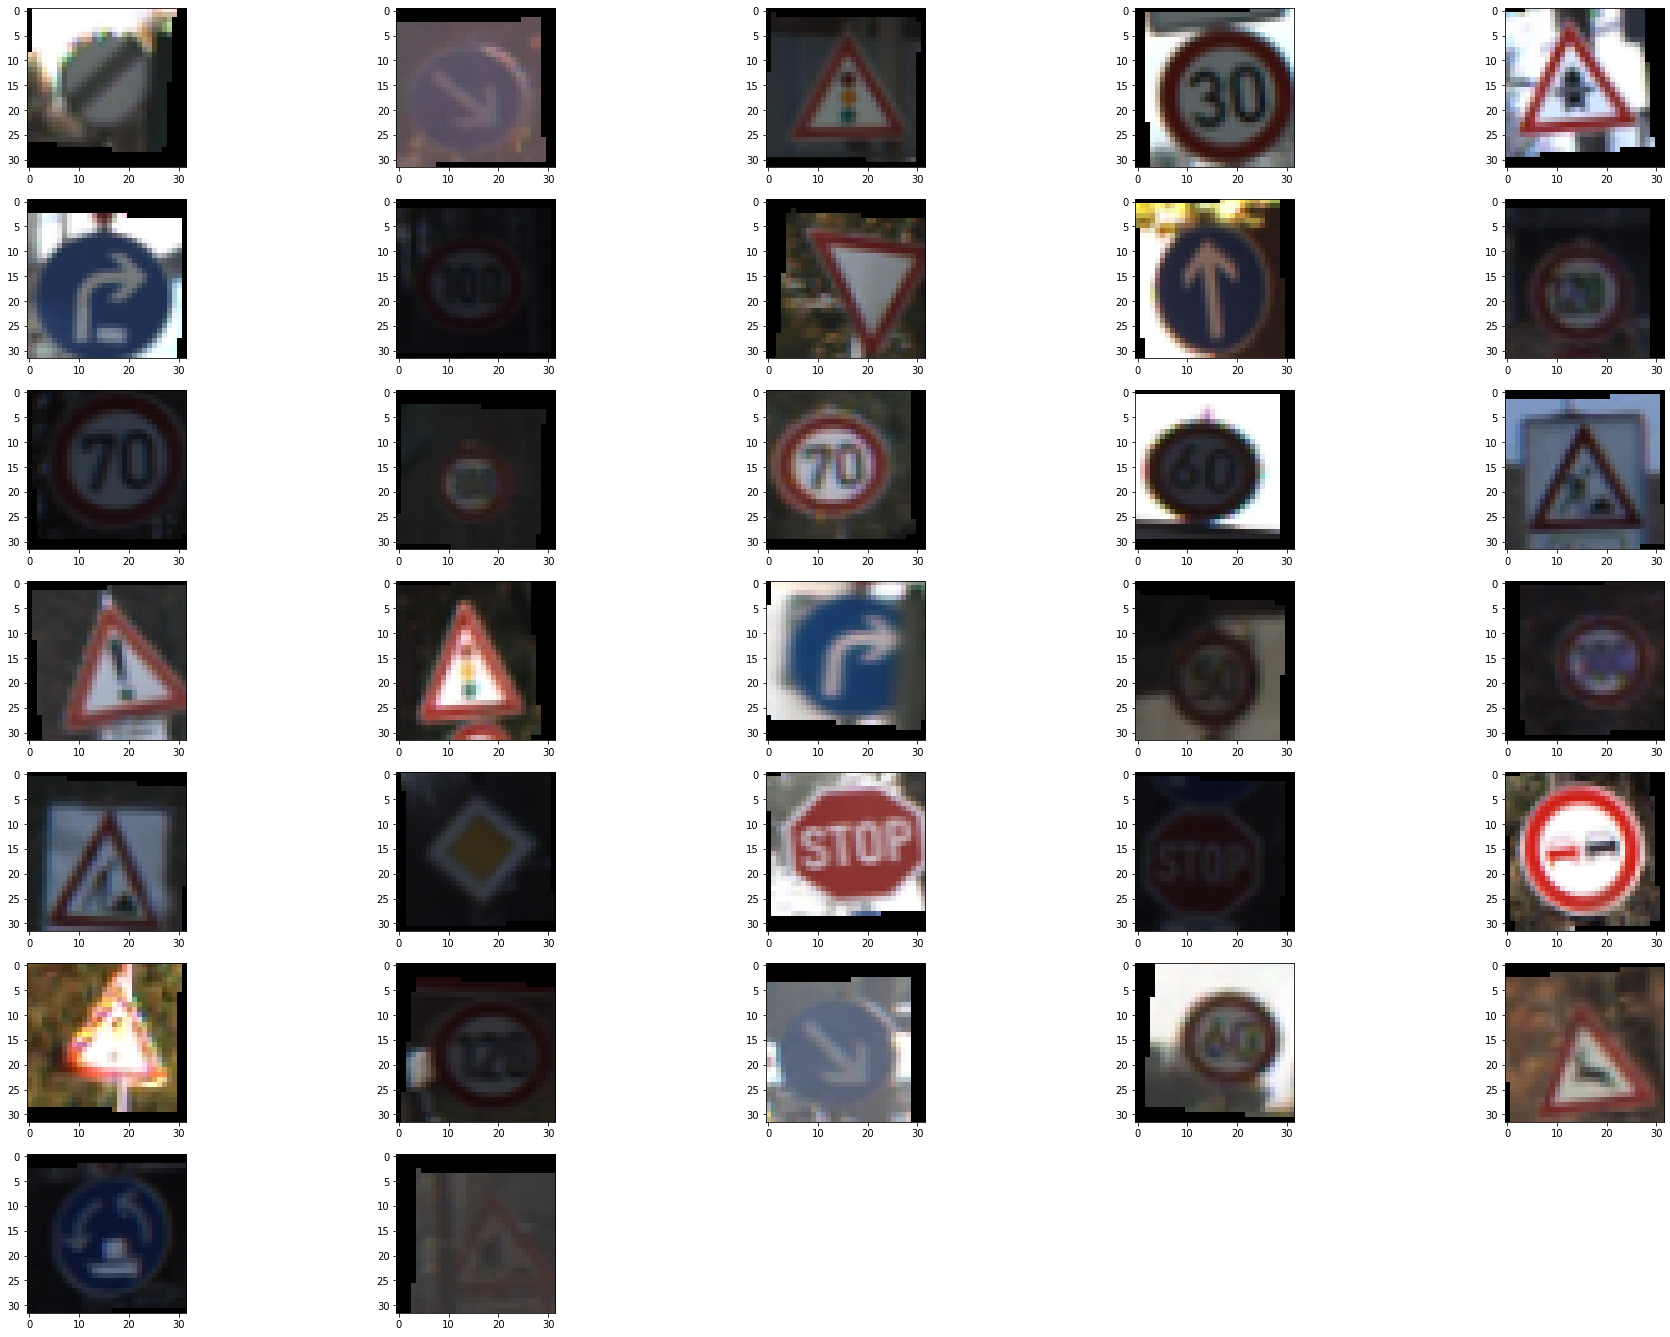

In [23]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
plt.show()

## 8. TRANSFER LEARNING - (ResNet50)

In [24]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False
# x1 = base_model(base_model.input, training = False)
# x2 = tf.keras.layers.Flatten()(x1)
# out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
x1 = base_model.output
x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x3 = tf.keras.layers.BatchNormalization()(x2)
x4 = tf.keras.layers.Dense(1024, activation='relu')(x3)
x5 = tf.keras.layers.BatchNormalization()(x4)
out = tf.keras.layers.Dense(num_classes, activation='softmax')(x5)
model = tf.keras.Model(inputs = base_model.input, outputs =out)
print(model.summary())


94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_____________________________

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_flow,epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/100
919/919 [==============================] - 63s 32ms/step - loss: 3.1152 - accuracy: 0.2223 - val_loss: 2.3537 - val_accuracy: 0.3532
Epoch 2/100
919/919 [==============================] - 28s 31ms/step - loss: 2.2565 - accuracy: 0.3690 - val_loss: 2.0643 - val_accuracy: 0.4111
Epoch 3/100
919/919 [==============================] - 28s 31ms/step - loss: 2.0754 - accuracy: 0.4023 - val_loss: 1.9619 - val_accuracy: 0.4479
Epoch 4/100
919/919 [==============================] - 28s 31ms/step - loss: 1.9549 - accuracy: 0.4276 - val_loss: 1.8994 - val_accuracy: 0.4500
Epoch 5/100
919/919 [==============================] - 28s 31ms/step - loss: 1.8670 - accuracy: 0.4571 - val_loss: 1.7206 - val_accuracy: 0.4976
Epoch 6/100
919/919 [==============================] - 28s 31ms/step - loss: 1.7869 - accuracy: 0.4732 - val_loss: 1.7496 - val_accuracy: 0.4861
Epoch 7/100
919/919 [==============================] - 28s 31ms/step - loss: 1.7172 - accuracy: 0.4883 - val_loss: 1.6679 - val_ac

In [26]:
metrics = model.evaluate(X_test_norm, Y_test_oh)

395/395 [==============================] - 7s 17ms/step - loss: 1.6839 - accuracy: 0.5742


In [27]:
model = tf.keras.models.load_model(model_name)
model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())
model.fit(train_flow, epochs = 100, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [28]:
metrics = model.evaluate(X_test_norm, Y_test_oh)

395/395 [==============================] - 7s 16ms/step - loss: 0.1866 - accuracy: 0.9609


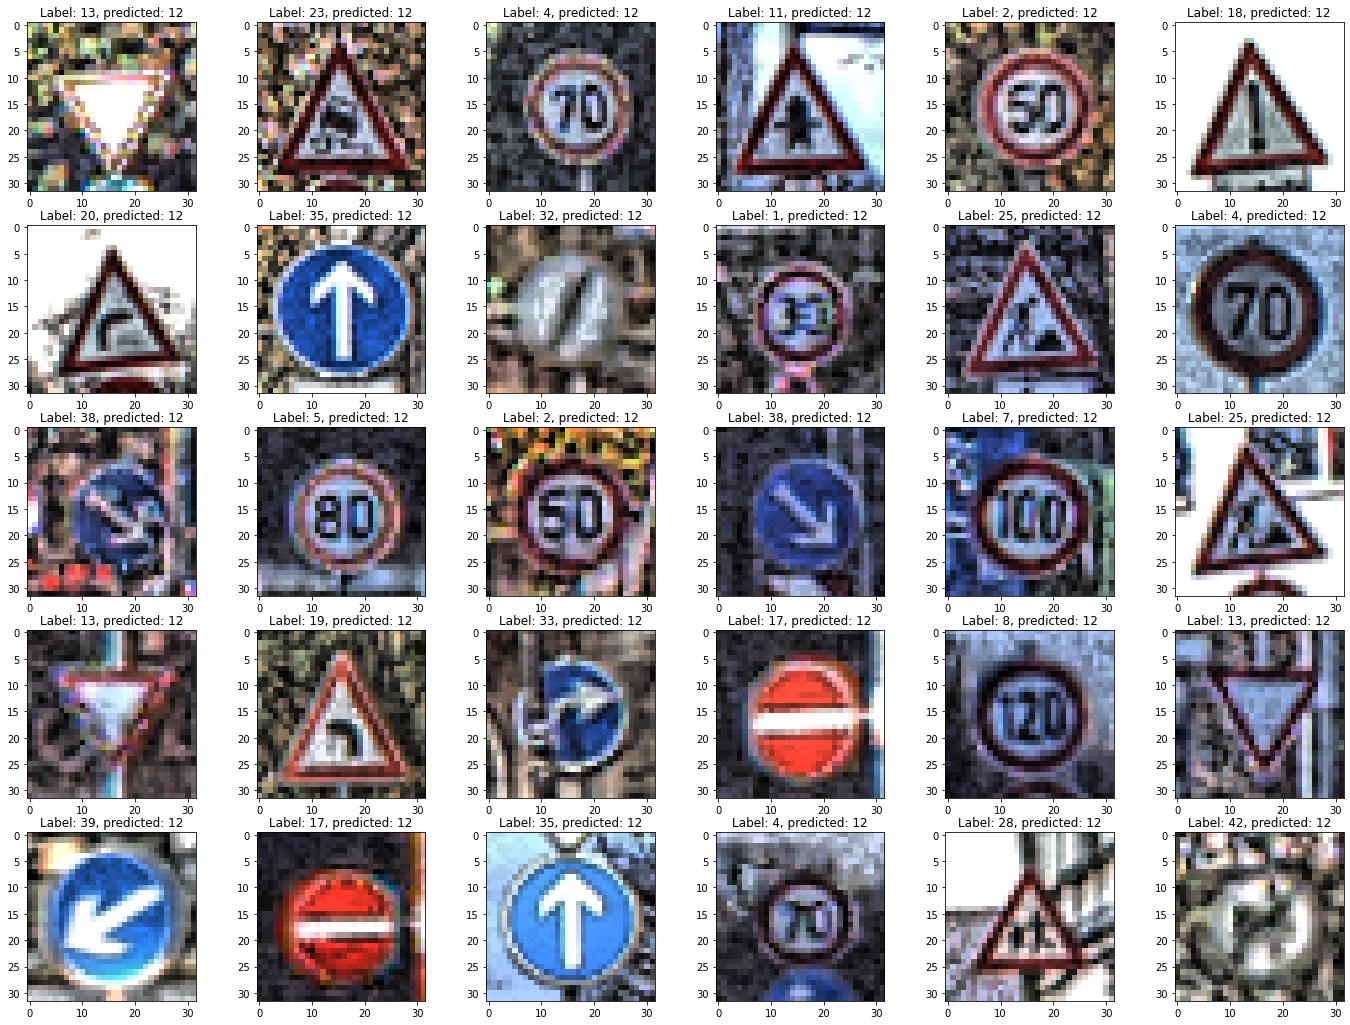

In [29]:
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

In [30]:
Y_test_pred = model.predict(X_test_norm)

In [ ]:
from sklearn import metrics

classes_names = []
for key,value in classes.items():
  classes_names.append(value)

print(metrics.classification_report(Y_test_ori, Ypred, digits=3, target_names=classes_names))

In [31]:
matrix = tf.math.confusion_matrix(Y_test_oh.argmax(axis=1), Y_test_pred.argmax(axis=1))

In [32]:
con_mat = matrix.numpy()

classes_names = []
for key,value in classes.items():
  classes_names.append(value)
  
con_mat_df = pd.DataFrame(con_mat, index=classes_names, columns=classes_names)

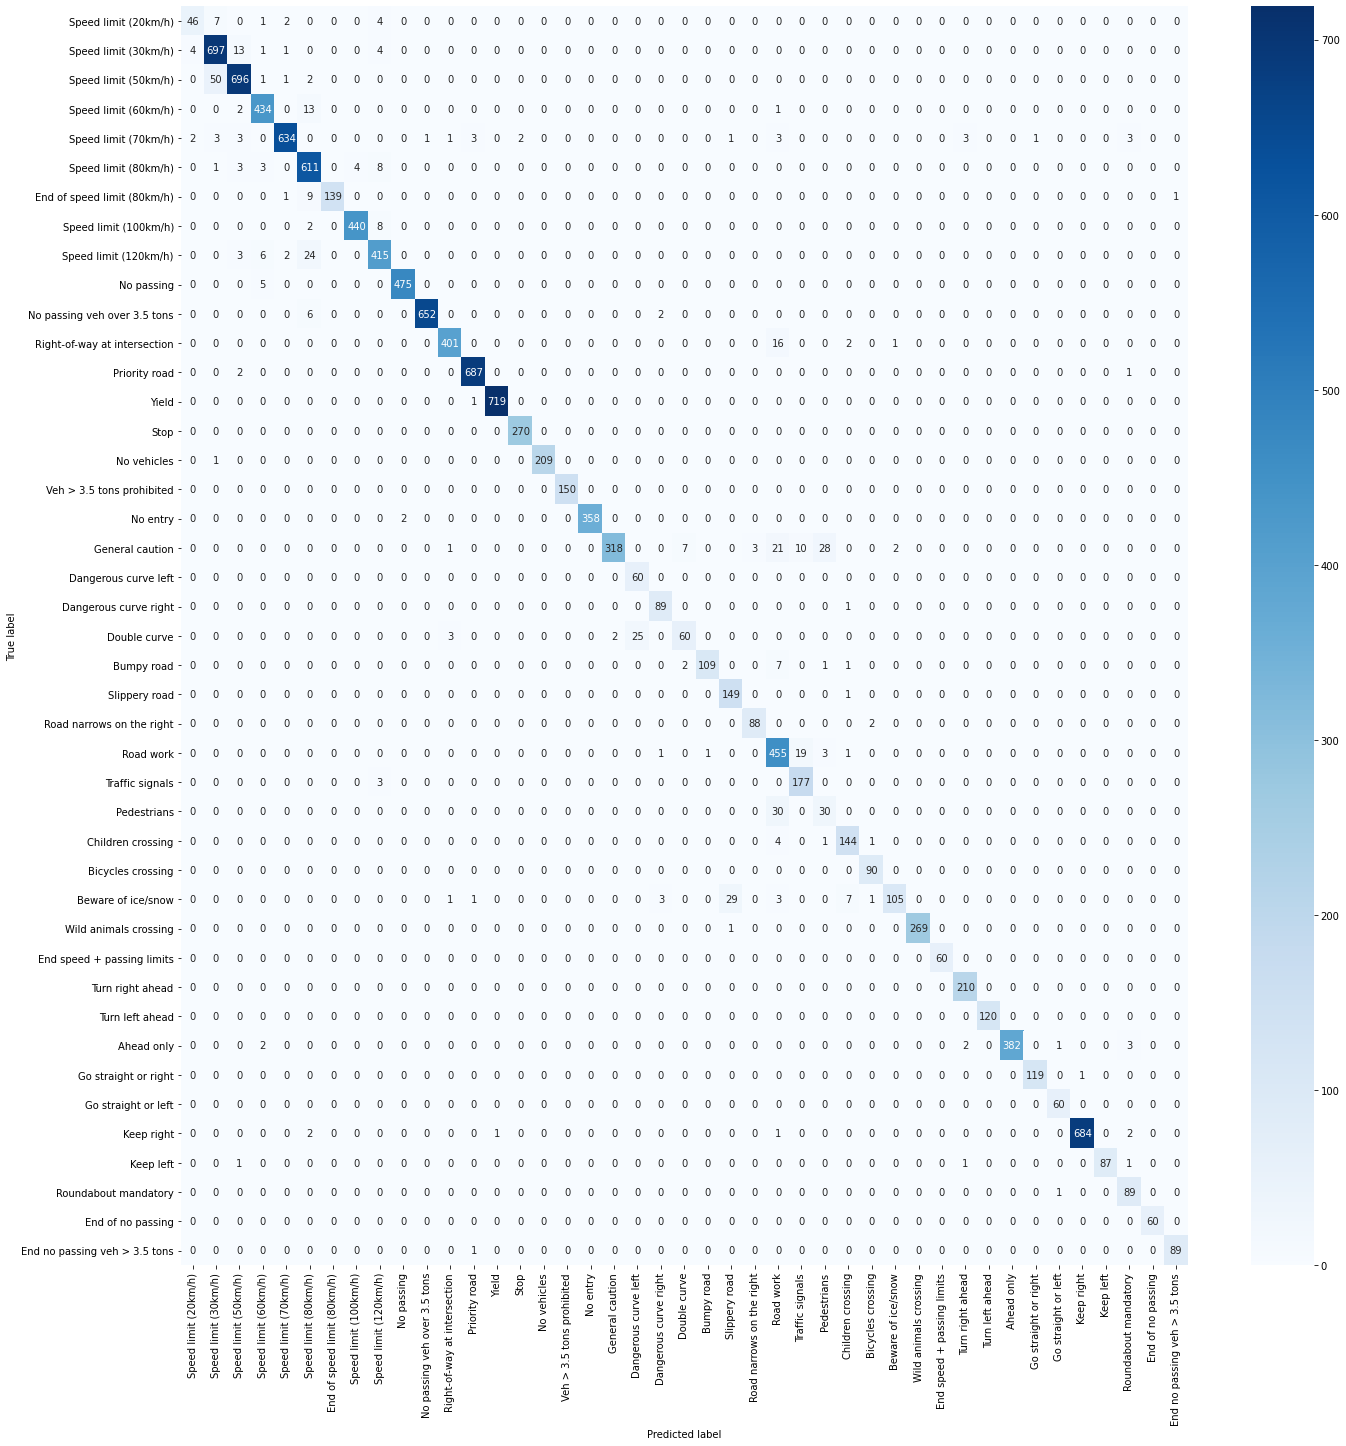

In [33]:
import seaborn as sns

figure = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

                               precision    recall  f1-score   support

         Speed limit (20km/h)      0.000     0.000     0.000        60
         Speed limit (30km/h)      0.000     0.000     0.000       720
         Speed limit (50km/h)      0.000     0.000     0.000       750
         Speed limit (60km/h)      0.000     0.000     0.000       450
         Speed limit (70km/h)      0.000     0.000     0.000       660
         Speed limit (80km/h)      0.000     0.000     0.000       630
  End of speed limit (80km/h)      0.000     0.000     0.000       150
        Speed limit (100km/h)      0.000     0.000     0.000       450
        Speed limit (120km/h)      0.000     0.000     0.000       450
                   No passing      0.000     0.000     0.000       480
 No passing veh over 3.5 tons      0.000     0.000     0.000       660
 Right-of-way at intersection      0.000     0.000     0.000       420
                Priority road      0.055     1.000     0.104       690
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
